In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from os import listdir
from os.path import isfile, join, isdir
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes
import math
from scipy.interpolate import spline
from scipy.interpolate import make_interp_spline, BSpline
from scipy.ndimage.filters import gaussian_filter1d

First of all, we are looking at the positions of air pollutants stations throught Europe


In [4]:
import chardet
RELATIVE_DATA_PATH = './data'

# Load metadata
metadata = pd.read_csv(join(RELATIVE_DATA_PATH, 'metadata.csv'))
metadata.columns


Index(['Countrycode', 'Namespace', 'AirQualityNetwork', 'AirQualityStation',
       'AirQualityStationNatCode', 'AirQualityStationEoICode',
       'AirQualityStationArea', 'SamplingPoint', 'SamplingProcess', 'Sample',
       'BuildingDistance', 'EquivalenceDemonstrated', 'InletHeight',
       'KerbDistance', 'MeasurementEquipment', 'MeasurementType',
       'MeasurementMethod', 'AirPollutantCode', 'AirPollutant',
       'AirQualityStationType', 'Projection', 'Longitude', 'Latitude',
       'Altitude'],
      dtype='object')

In [5]:
# Load data
def loadDataPollutant(countries, pollutant, cols):
    print(f"Loading pollutant: ${pollutant}")
    countries_data = {}
    for country in countries: #countries[:2]:
        frames = []
        print(f"Parsing {country}\n")
        pollutantsPath = join(RELATIVE_DATA_PATH, country)
        pollutantsPath = pollutantsPath + pollutant
        pollutants = listdir(pollutantsPath)
        
        if not pollutants:
            continue
            
        for dataCSV in pollutants:
            dataCSVPath = join(pollutantsPath, dataCSV)        
            with open(dataCSVPath, 'rb') as f:
                info = chardet.detect(f.read())
                currentCSV = pd.read_csv(dataCSVPath, sep=',', usecols=cols, encoding=info.get('encoding'))

                data = pd.DataFrame(currentCSV)

                # Convert data columns
                try:
                    data.DatetimeBegin = pd.to_datetime(data.DatetimeBegin, utc = True)
                    data.DatetimeEnd = pd.to_datetime(data.DatetimeEnd, utc = True)
                    # Set index
                    data.set_index(['DatetimeBegin'], inplace = True)
                    # Sort by index (by DatetimeBegin)
                    data.sort_index(inplace=True)
                    # Keep only one entry per sensor for each day
                    # data = data.iloc[12::24, :]
                    frames.append(data)
                except:
                    print("No datetime data")
        countries_data[country] = pd.concat(frames)
    print('End')
    return countries_data


In [42]:
# Load O3 data for CH, ES, FI and PT
countries = ['CH', 'ES', 'FI', 'PT']
pollutants = ['/CO/', '/NO2/', '/SO2']
cols = ['Countrycode', 'AirQualityStation', 'Concentration', 'DatetimeBegin', 'DatetimeEnd', 'AirPollutant']

countries_data = pd.DataFrame()
for pollutant in pollutants:
    currentPollutantData = pd.concat(loadDataPollutant(countries, pollutant, cols).values(), sort=True)
    countries_data = countries_data.append(currentPollutantData, ignore_index=False)


Loading pollutant: $/CO/
Parsing CH

Parsing ES

Parsing FI

Parsing PT

End
Loading pollutant: $/NO2/
Parsing CH

Parsing ES

Parsing FI

Parsing PT

End
Loading pollutant: $/SO2
Parsing CH

Parsing ES

Parsing FI

Parsing PT

End


In [43]:
# Save data to pickle
countries_data.to_pickle("./countried_data.pkl")


In [44]:
# Join with metadata (get Longitude and Latitude)
metadata_subset = metadata[['Latitude', 'Longitude','Countrycode', 'AirQualityStation']]
metadata_subset = metadata_subset[ metadata_subset.Latitude.notna() & metadata_subset.Longitude.notna() ]
spatial_data = pd.merge(countries_data, metadata_subset, how='inner', left_on = ['Countrycode', 'AirQualityStation'], right_on =['Countrycode', 'AirQualityStation'])
spatial_data = spatial_data.drop_duplicates(subset='AirQualityStation', keep="last")
spatial_data.geometry = spatial_data.apply(lambda row: Point(row.Longitude, row.Latitude), axis = 1)
spatial_data.to_pickle("./spatial_data.pkl")

spatial_data.head()


/Users/so/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


,AirPollutant,AirQualityStation,Concentration,Countrycode,DatetimeEnd,Latitude,Longitude
11230,SO2,STA_ES1978A,1.0,ES,2016-12-31 02:00:00+00:00,28.498380,-13.860830
15514,NO2,STA_ES2069A,25.0,ES,2016-12-31 21:00:00+00:00,43.522900,-5.689500
24034,SO2,STA_ES1649A,2.0,ES,2016-12-31 04:00:00+00:00,42.176000,-1.744000
28372,NO2,STA_ES1442A,28.0,ES,2016-12-31 15:00:00+00:00,43.064167,-2.490000
40692,NO2,STA_ES1617A,18.0,ES,2016-12-31 02:00:00+00:00,39.150000,-0.457778


In [45]:
# Set filepath
fp = "./L2_data/Europe_borders.shp"

# Read file using gpd.read_file()
europeMap = gpd.read_file(fp)


We can observe that from the countries analyzed Spain has the biggest density of pollutant analyzer stations

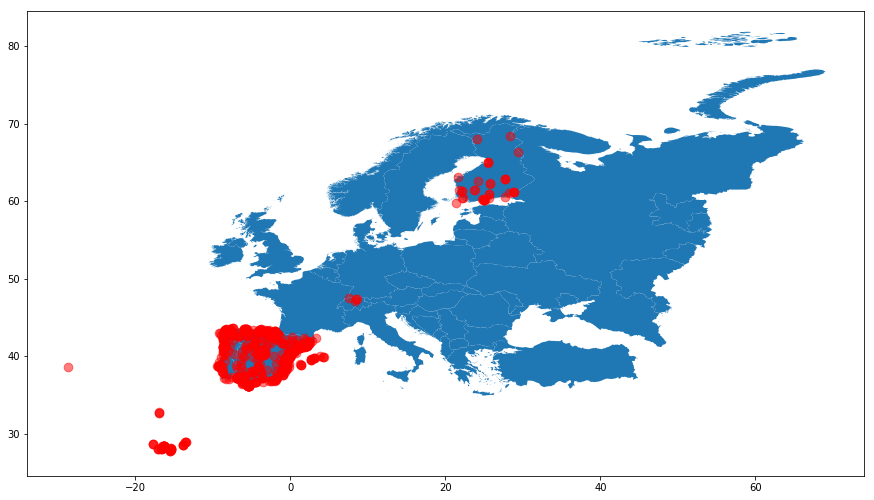

In [46]:
fig, ax = plt.subplots(figsize = (15, 15))
crs = {'init': 'epsg:4326'}
europeMapDs = gpd.GeoDataFrame(spatial_data, crs=crs, geometry=spatial_data.geometry)
europeMap.plot(ax = ax)
europeMapDs.geometry.plot(marker='o', color = 'red', ax = ax, label = 'WNV-', alpha=.5, markersize = 75)


For each country we are going to choose a AirQualityStation and compare the values of their pollutants

country CH, pollutant CO, station STA-CH0013A -> count: 1092
country ES, pollutant CO, station STA_ES1978A -> count: 1021
country FI, pollutant CO, station STA-FI00186 -> count: 372
country PT, pollutant CO, station STA-PT03075 -> count: 709
country CH, pollutant NO2, station STA-CH0008A -> count: 729
country ES, pollutant NO2, station STA_ES0373A -> count: 717
country FI, pollutant NO2, station STA-FI00273 -> count: 365
country PT, pollutant NO2, station STA-PT01041 -> count: 123
country CH, pollutant SO2, station STA-CH0011A -> count: 1096
country ES, pollutant SO2, station STA_ES1802A -> count: 1086
country FI, pollutant SO2, station STA-FI00339 -> count: 360
country PT, pollutant SO2, station STA-PT02018 -> count: 545


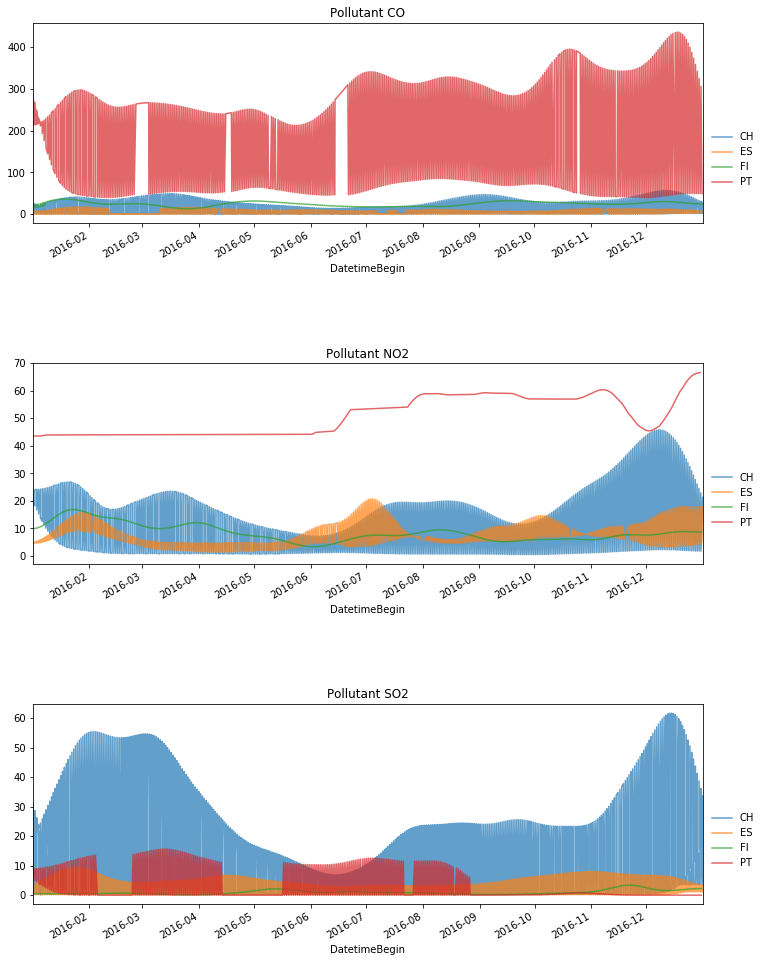

In [88]:
ncols = 1
nrows = len(pollutants)
fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(12, 6 * nrows))
plt.subplots_adjust(hspace = 0.7)

# For each country, taking by random a certain station
indx = 0
for pollutant in pollutants:
    pollutant = pollutant.split('/')[1]
  
    for country in countries:
        countryData = countries_data[ (countries_data.Countrycode == country) & (countries_data.AirPollutant == pollutant) ]
        if countryData.Concentration.count() == 0:
            continue
            
        station = countryData.iloc[0].AirQualityStation
        measurementsForStation = countries_data[ countries_data.AirQualityStation == station ].copy()
        print(f"country {country}, pollutant {pollutant}, station {station} -> count: {measurementsForStation.Concentration.count()}")
        
        measurementsForStation['ConcentrationSmooth'] = gaussian_filter1d(measurementsForStation.Concentration, sigma=10)
        measurementsForStation.ConcentrationSmooth.plot(ax = axes[indx], label = country, alpha = 0.7)

        
    axes[indx].legend( frameon=False,  bbox_to_anchor=(1.0, 0.5))
    axes[indx].title.set_text(f"Pollutant {pollutant}")
    indx += 1
       

We are going to compute a ranking with all the values


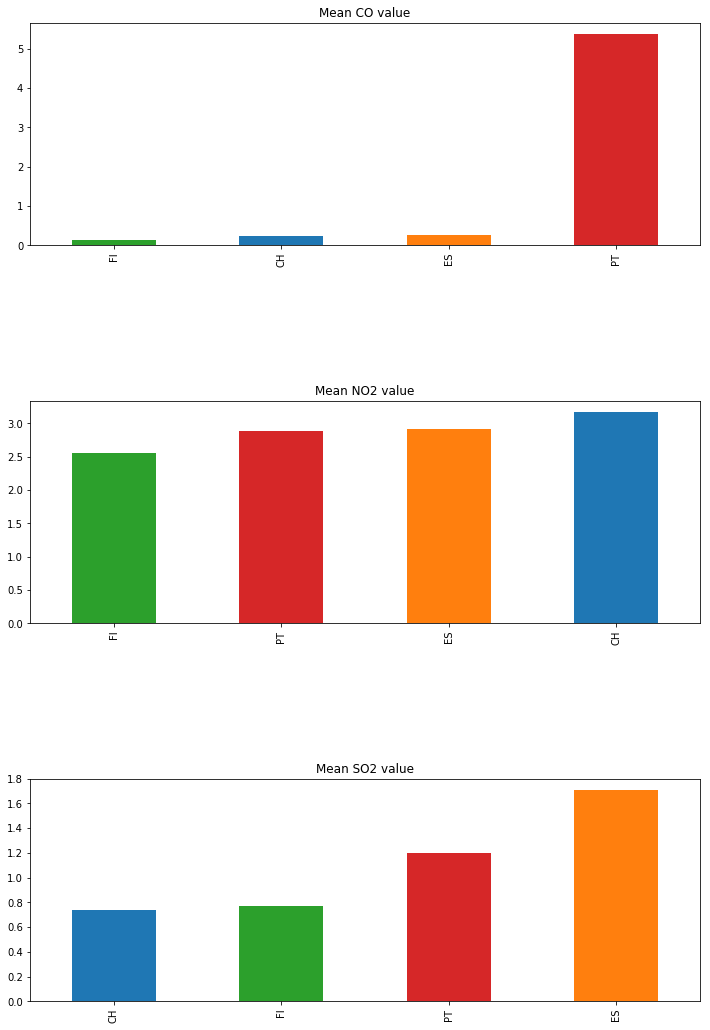

In [129]:
ncols = 1
nrows = len(pollutants)
fig, axes = plt.subplots(nrows=nrows, ncols = ncols, figsize=(12, 6 * nrows))
plt.subplots_adjust(hspace = 0.7)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# For each country, taking by random a certain station
indx = 0
for pollutant in pollutants:
    pollutant = pollutant.split('/')[1]
    
    packed = []
    i = 0
    for country in countries:
        countryData = countries_data[ (countries_data.Countrycode == country) & (countries_data.AirPollutant == pollutant) ]
        computedMean = countryData.Concentration.mean()
        packed.append( (computedMean, country, colors[i]) )
        i += 1
    packed = sorted(packed, key=lambda x: x[0])
    
    sortedMean = []
    sortedCountry = []
    sortedColors = []
    for val in packed:
        sortedMean.append(val[0])
        sortedCountry.append(val[1])
        sortedColors.append(val[2])
        
    concentrationSeries = np.log(pd.Series(sortedMean) + 1)

    concentrationSeries.plot.bar(ax = axes[indx], color=sortedColors)
    
    axes[indx].title.set_text(f"Mean {pollutant} value")
    axes[indx].set_xticklabels(sortedCountry)
    indx += 1
